In [ ]:
# default_exp bap_logistic_regression

# bap_logistic_regression

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
from scipy.special import expit as logistic
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

RANDOM_SEED = 123

## 1. Logistic regression

#### The IRIS dataset

In [ ]:
# iris = sns.load_dataset("iris")
iris = pd.read_csv("data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
iris.shape

(150, 5)

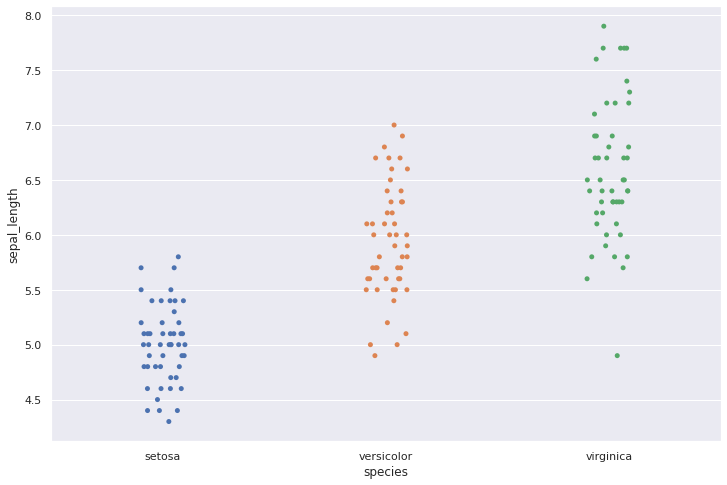

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)

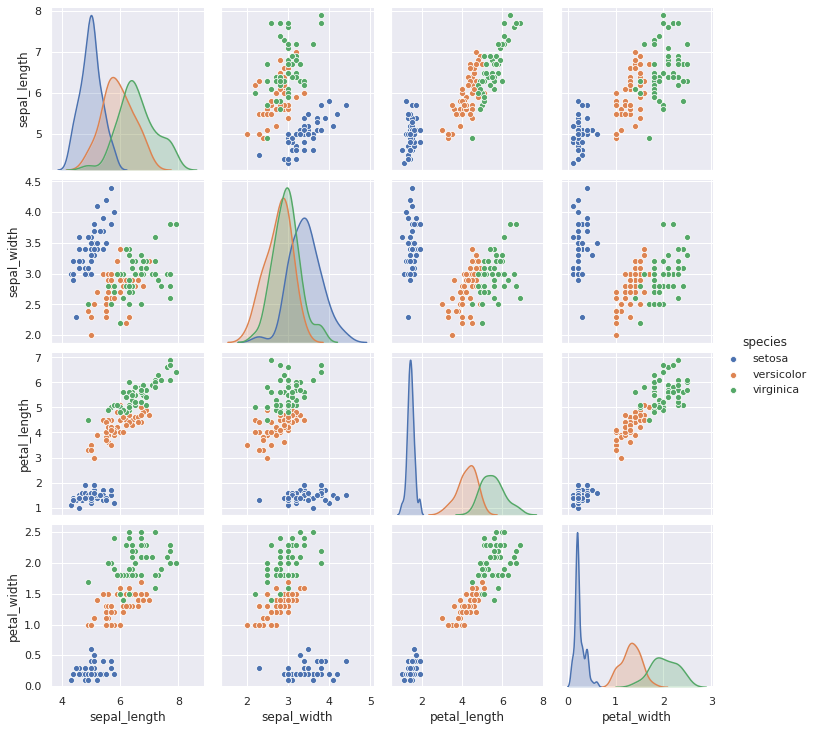

In [ ]:
sns.pairplot(iris, hue='species', diag_kind='kde')

#### The logistic model

In [ ]:
# Data preprocessing
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_label = 'sepal_length'
x_0 = df[x_label].values
x_center = x_0 - x_0.mean()

In [ ]:
df.shape

(100, 5)

In [ ]:
# model
with pm.Model() as logit_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_center, β)
    #θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    
    trace_0 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_0, var_names=['α', 'β', 'bd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.309,0.341,-0.300,0.965,0.005,0.004,4986.0,4353.0,5001.0,4957.0,1.0
β,5.387,1.037,3.533,7.335,0.014,0.010,5400.0,4981.0,5670.0,4488.0,1.0
bd,-0.056,0.063,-0.173,0.063,0.001,0.001,5180.0,4857.0,5176.0,5129.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbeb54cbf90>,
      dtype=object)

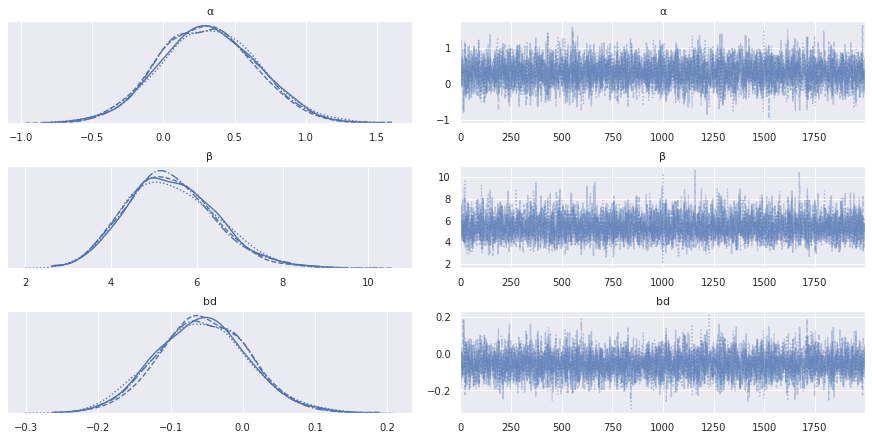

In [ ]:
pm.traceplot(trace_0, ['α', 'β', 'bd'])

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/opt/conda/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (8000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,


([<matplotlib.axis.XTick at 0x7fbecdb7df50>,
 [Text(0, 0, '4.0'),
  Text(0, 0, '4.5'),
  Text(0, 0, '5.0'),
  Text(0, 0, '5.5'),
  Text(0, 0, '6.0'),
  Text(0, 0, '6.5'),
  Text(0, 0, '7.0'),
  Text(0, 0, '7.5')])

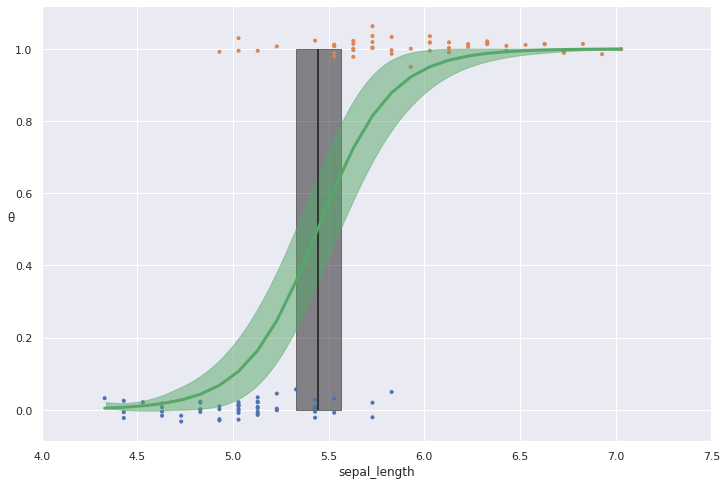

In [ ]:
# Visual posterior dist and observed data
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_center)
plt.plot(x_center[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_center, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_center, trace_0['θ'], color='C2')

plt.xlabel(x_label)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

#### Prediction

In [ ]:
def classify(n, threshold):
    n = np.array(n)
    mu = trace_0['α'].mean() + trace_0['β'].mean() * n
    prob = 1 / (1 + np.exp(-mu))s
    return prob, prob > threshold

In [ ]:
# Test
classify([5, 5.5, 6], 0.4)

(array([1., 1., 1.]), array([ True,  True,  True]))

In [ ]:
y_prob, y_pred = classify(x_center, 0.5)
accuracy = (y_pred == (y_0 == 1)).mean()
accuracy

## 2. Multiple logistic regression

#### Data preparation

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_1 = df[x_n].values

#### Model

In [ ]:
with pm.Model() as multiple_logit:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n))
    
    μ = α + pm.math.dot(x_1, β)
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_1)
    
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbeaa6bfd50>,
      dtype=object)

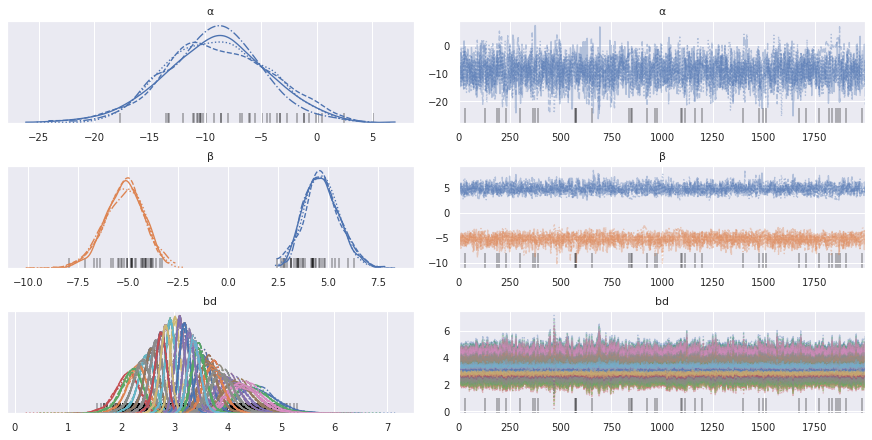

In [ ]:
pm.traceplot(trace_1, var_names=['α', 'β', 'bd'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbea9cb3fd0>],
      dtype=object)

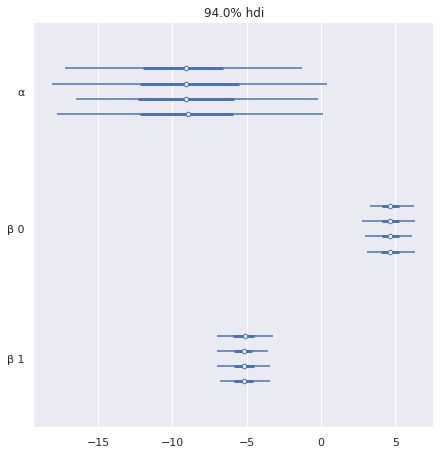

In [ ]:
var_names = ['α', 'β']
az.plot_forest(trace_1, var_names=var_names)

/opt/conda/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (8000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,


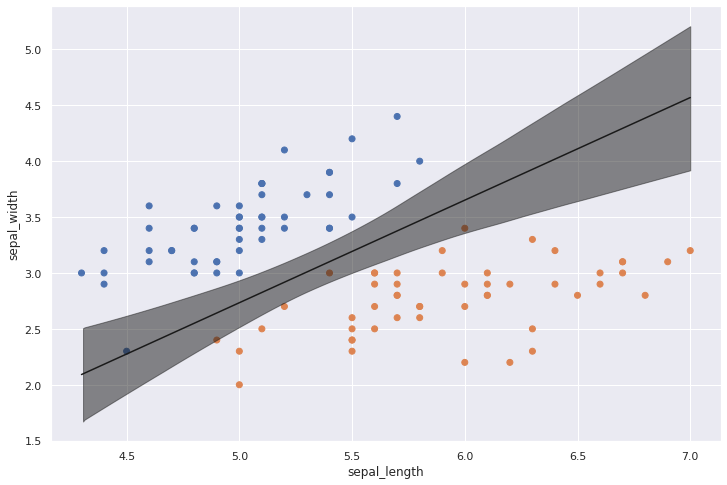

In [ ]:
# Plot posterior dist with observed data
idx = np.argsort(x_1[:,0]) 
bd = trace_1['bd'].mean(0)[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hpd(x_1[:,0], trace_1['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
plt.savefig('B11197_04_05.png', dpi=300);

#### Prediction

In [ ]:
def classify(x_1, threshold):
    x_1 = np.array(x_1)
    mu = trace_1['α'].mean() + trace_1['β'][:,0].mean() * x_1[:,0] + trace_1['β'][:,1].mean() * x_1[:,1]
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob > threshold

In [ ]:
x_1[:,1]

array([3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
       3. , 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. ,
       3.4, 3.5, 3.4, 3.2, 3.1, 3.4, 4.1, 4.2, 3.1, 3.2, 3.5, 3.6, 3. ,
       3.4, 3.5, 2.3, 3.2, 3.5, 3.8, 3. , 3.8, 3.2, 3.7, 3.3, 3.2, 3.2,
       3.1, 2.3, 2.8, 2.8, 3.3, 2.4, 2.9, 2.7, 2. , 3. , 2.2, 2.9, 2.9,
       3.1, 3. , 2.7, 2.2, 2.5, 3.2, 2.8, 2.5, 2.8, 2.9, 3. , 2.8, 3. ,
       2.9, 2.6, 2.4, 2.4, 2.7, 2.7, 3. , 3.4, 3.1, 2.3, 3. , 2.5, 2.6,
       3. , 2.6, 2.3, 2.7, 3. , 2.9, 2.9, 2.5, 2.8])

In [ ]:
y_prob, y_pred = classify(x_1, 0.5)
accuracy = (y_pred == (y_0 == 1)).mean()
accuracy

1.0